# Classification of the CIFAR-10 dataset using CNNs

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) provides 60000 32x32-pixel images, classified into 10 categories. The figure below provides a random sample of some images in each category.

![](cifar_images.png)

During this exercise, you are asked to build a Convolutional Neural Network (CNN), which (when trained) will be able to automatically classify new images into one of these categories. We will make use of the [Keras library](https://www.tensorflow.org/guide/keras) which provides a high-level interface to TensorFlow, which you have already seen.

## Introduction to Keras

Keras is a high-level API to build and train deep learning models. It's used for fast prototyping, advanced research, and production, with three key advantages:

- __User friendly__: Keras has a simple, consistent interface optimized for common use cases. It provides clear and actionable feedback for user errors.
- __Modular and composable__: Keras models are made by connecting configurable building blocks together, with few restrictions.
- __Easy to extend__: Write custom building blocks to express new ideas for research. Create new layers, loss functions, and develop state-of-the-art models.

In Keras, models are built by assembling multiple layers. Suppose we want to create a new multilayer perceptron model to categorize 128-feature data into 10 labeled categories. The Keras code could look like:

```python
# Create a sequential model
model = tf.keras.Sequential()
# Adds a densely-connected layer with 64 units to the model
model.add(layers.Dense(64, activation='relu'), input_shape=[128])
# Add another
model.add(layers.Dense(32, activation='relu'))
# Add a softmax layer with 10 output units
model.add(layers.Dense(10, activation='softmax'))
```

The `input_shape` argument must be given for the first layer in the model, however all other layers will automatically determine the input shape based on the previous layer in the model. Note that the code above is substantially simpler than the corresponding TensorFlow code. This is particular useful for building convolutional or other types of layers, as we will see.

Once built, a model's learning can be configured with the `compile()` function

```python
model.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.train.AdamOptimizer(0.001), 
    metrics=['accuracy'])
```

In this case, a cross-entropy loss function is used with the ADAM optimization algorithm. The `metrics` argument allows the model to keep track of a number of [training metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) during training.

Once configured, training is performed using the `fit()` function.

```python
model.fit(data, labels, epochs=10, batch_size=32)
```

The function takes an array-like (could be numpy array) of data and the corresponding target values, and performs the optimization of the learnable parameters in the model. See the documentation for the [fit()](https://www.tensorflow.org/api_docs/python/tf/keras/models/Model#fit) function for more details.

Once trained, the model can be used to predict, using the `predict()` function. 

```python
prediction = model.predict(new_data)
```
  
## Tasks

Begin by importing the necessary modules.

In [1]:
import matplotlib.pyplot as plt
import tensorflow.keras.datasets.cifar10 as cifar10
import tensorflow.keras.datasets.mnist as mnist
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (Activation, BatchNormalization, Conv2D,
                                     Dense, Dropout, Flatten, MaxPooling2D)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

### Understand the dataset

Understanding your dataset is the first prerequisit to training any model. The CIFAR-10 dataset is provided directly from Keras.  

- Download the dataset. See [`tf.keras.datasets`](https://keras.io/datasets/) for how to download the data, and what format it is provided. Note that the dataset is already divided into a training set of 50000 images, and a test set of 10000.
- Verify that the shape of the image and target arrays are what you expect.
- Create a list of labels corresponding to the 10 categories. This will be used to convert the 0-9 digits in the target arrays to string labels. The categories are labeled as follows:

  0. airplane
  1. automobile
  2. bird
  3. cat
  4. deer
  5. dog
  6. frog
  7. horse
  8. ship
  9. truck
  
- Visualize some images in each category using the `imshow()` function in `matplotlib.pyplot`. Can you recreate the figure at the top?  Hint: the top figure was created using the first 8 images belonging to each category in the training data.
- Normalize the image data from [0,255] to be [0,1]. Normalizing improves model training. (to test this, you can comment out the normalization later)
- Lastly, convert the target arrays to one-hot encodings. Hint: checkout the [`tf.keras.utils.to_categorical()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical)

In [26]:
def load_cifar_data():
    """
    Loads the CIFAR-10 dataset using Keras and preprocess for training.
    """
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()

    # Create target labels
    labels = ["airplane", "automobile", "bird", "cat", "deer", "dog",
        "frog", "horse", "ship", "truck"]

    return X_train/255.0, y_train, X_test/255.0, y_test, labels

# Load data
X_train, y_train, X_test, y_test, labels = load_cifar_data()

X_train shape: (50000, 32, 32, 3).
y_train shape: (50000, 1).


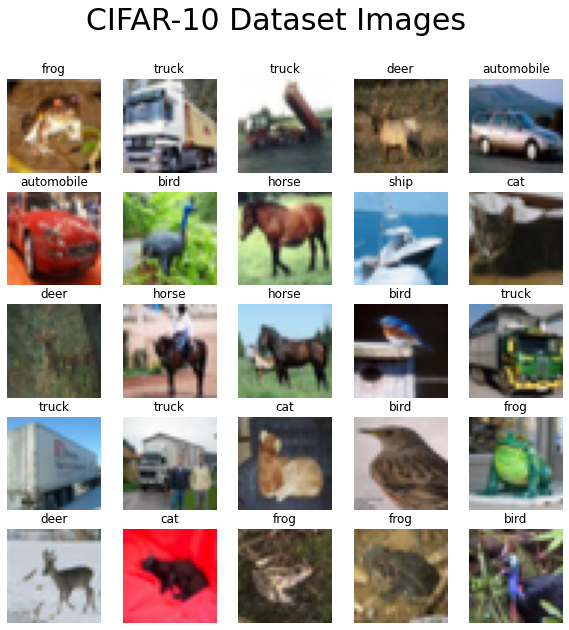

In [27]:
# Inspect dataset shape
print(f"X_train shape: {X_train.shape}.", f"y_train shape: {y_train.shape}.", 
    sep='\n')

# Plot images
fig = plt.figure(figsize=(10,10))
fig.suptitle('CIFAR-10 Dataset Images', fontsize=30)

for i in range(25):
    fig.add_subplot(5, 5, i+1)
    plt.imshow(X_train[i])
    plt.axis('off')
    plt.title(labels[y_train[i,0]])

In [28]:
# One-hot encode target data
y_train_oh = to_categorical(y_train, 10)
y_test_oh = to_categorical(y_test, 10)

print(f"One-hot encoded y_train shape: {y_train_oh.shape}.", 
    f"One-hot encoded y_train shape: {y_test_oh.shape}.", sep='\n')

One-hot encoded y_train shape: (50000, 10).
One-hot encoded y_train shape: (10000, 10).


### First naive model

In order to better understand the importance of CNNs, it is instructive to first see how well a naive dense network performs on the dataset.

- Create a sequential model with 4 `Dense` hidden layers of 2048, 1024, 512, and 256 nodes each, with ReLU activation, and a linear output layer of 10 nodes. Note that you will need to use the `Flatten` layer first in order to convert the 3D (x, y, rgb) image data into 1D.
- Compute by hand the total number of trainable parameters (weights and biases) in the model.
- Compile the model with a `categorical_crossentropy` loss, using the SGD optimizer, including the `accuracy` metric.
- Use the `summary()` function on model to get a text summary of the model. Did you compute the number of parameters correctly?
- Train the model:
  - Start with small batch size of 32 and train for 10 epochs
  - Use early stopping on the validation accuracy with a patience of 2
- How does the model perform? Is it any better than a random guess? 
- Try changing the batch size to see if there is any improvement.
- Try adding batch normalization after each hidden layer. Any better?

In [29]:
def dense_model(input_shape, num_classes):
    # Initialize model object
    model = Sequential()

    # Add layers
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(2048, activation='ReLU', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dense(1024, activation='ReLU'))
    model.add(BatchNormalization())
    model.add(Dense(512, activation='ReLU'))
    model.add(BatchNormalization())
    model.add(Dense(256, activation='ReLU'))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='Softmax'))

    # Set optimizer
    optimizer = SGD(learning_rate=0.01)

    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', 
        metrics=['accuracy'])

    return model

In [30]:
def train_model(model, x, y, x_test, y_test, batch_size=128, epochs=10):
    # Set early stopping
    early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=2)

    # Fit model to data
    model.fit(x, y, validation_data=(x_test, y_test), epochs=epochs,
        batch_size=batch_size, callbacks=[early_stopping_monitor])

In [38]:
# Instantiate model
model_dense = dense_model(X_train.shape[1:], 10)

In [41]:
# Print summary of compiled model
model_dense.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 3072)              0         
                                                                 
 batch_normalization_32 (Bat  (None, 3072)             12288     
 chNormalization)                                                
                                                                 
 dense_28 (Dense)            (None, 2048)              6293504   
                                                                 
 batch_normalization_33 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense_29 (Dense)            (None, 1024)              2098176   
                                                                 
 batch_normalization_34 (Bat  (None, 1024)            

In [40]:
# Train model
train_model(model_dense, X_train, y_train_oh, X_test, y_test_oh, 64, 5)

Epoch 1/5
782/782 [==============================] - 70s 87ms/step - loss: 1.7060 - accuracy: 0.4092 - val_loss: 1.4937 - val_accuracy: 0.4686
Epoch 2/5
782/782 [==============================] - 66s 84ms/step - loss: 1.3366 - accuracy: 0.5301 - val_loss: 1.4327 - val_accuracy: 0.4969
Epoch 3/5
782/782 [==============================] - 61s 78ms/step - loss: 1.1682 - accuracy: 0.5921 - val_loss: 1.4227 - val_accuracy: 0.4958
Epoch 4/5
782/782 [==============================] - 72s 92ms/step - loss: 1.0294 - accuracy: 0.6412 - val_loss: 1.4460 - val_accuracy: 0.5015
Epoch 5/5
782/782 [==============================] - 62s 79ms/step - loss: 0.9089 - accuracy: 0.6861 - val_loss: 1.4285 - val_accuracy: 0.5214


<font color='#4863A0'>When training the model with parameters from the problem statement, the accuracy results are almost 50%, which coincides with random guessing. Increasing the batch size negatively affects the results, as the model is less able to optimize the coefficients. However, adding batch normalization to the hidden layers slightly improves the accuracy.</font>

### Convolutional Net

Convolutional neural networks allow us to do drastically better on this dataset (and many image classification problems in general). In this task, you will build your first convolutional network and see how it performs during training.

- Create a new model with the following layers
  - 3x3 2D convolution with zero padding (same), 32 filters
  - ReLU activation
  - 3,3 2D convolution, no padding, 32 filters
  - ReLU activation
  - Max pooling with size (2,2)
  - 3x3 2D convolution, no padding, 64 filters
  - ReLU activation
  - 3x3 2D convolution, no padding, 64 filters
  - ReLU activation
  - Max pooling with size (2,2)
  - Flatten
  - Dense layer with 512 nodes, ReLU activation
  - Softmax output layer with 10 nodes
- Compile the network with same optimizer and metrics as the dense network.
- Compute by hand the number of trainable parameters in this network. Are there more or less than the more simple dense network? Why? Confirm with `summary()`.
- Use the same training procedure as before for 10 epochs and batch size of 32.
- How does the validation accuracy change with each epoch?
- Increase the batch size to 64 and retrain. Better or worse? Try 128 as well. How does increasin the batch size improve the training?
- Note how the validation accuracy begins to decrease at some point, while the training accuracy continues to increase. What is this phenomena called? Try adding 3 dropout layers to the model, one before each max pooling layer and one before the last layer, using a dropout ratio of 0.25. Does this improve over-fitting?
- Play with batch normalization. For example, add batch normalization layers after each dropout layer. Do you notice a faster increase in the model improvement? Why?

In [34]:
def cnn_model(input_shape, num_classes):
    # Initialize model object
    model = Sequential()

    # Add layers
    model.add(Conv2D(32, kernel_size=3, padding='same', input_shape=input_shape))
    model.add(Activation('ReLU'))
    model.add(Conv2D(32, kernel_size=3, padding='same'))
    model.add(Activation('ReLU'))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2))
    model.add(Conv2D(64, kernel_size=3, padding='same'))
    model.add(Activation('ReLU'))
    model.add(Conv2D(64, kernel_size=3, padding='same'))
    model.add(Activation('ReLU'))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2))
    model.add(Flatten())
    model.add(Dense(512, activation='ReLU'))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='Softmax'))

    # Set optimizer
    optimizer = SGD(learning_rate=0.01)

    # Compile model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', 
        metrics=['accuracy'])

    return model

In [ ]:
# Instantiate model
model_cnn = cnn_model(X_train.shape[1:], 10)

In [36]:
# Print summary of compiled model
model_cnn.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_12 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 activation_13 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 dropout_9 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_29 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                      

In [37]:
# Train model
train_model(model_cnn, X_train, y_train_oh, X_test, y_test_oh, 64, 5)

Epoch 1/5
782/782 [==============================] - 195s 248ms/step - loss: 1.7140 - accuracy: 0.4132 - val_loss: 1.9993 - val_accuracy: 0.3316
Epoch 2/5
782/782 [==============================] - 201s 257ms/step - loss: 1.3255 - accuracy: 0.5331 - val_loss: 1.6388 - val_accuracy: 0.4088
Epoch 3/5
782/782 [==============================] - 192s 246ms/step - loss: 1.1599 - accuracy: 0.5880 - val_loss: 1.9137 - val_accuracy: 0.3842
Epoch 4/5
782/782 [==============================] - 192s 246ms/step - loss: 1.0413 - accuracy: 0.6297 - val_loss: 1.3510 - val_accuracy: 0.5235
Epoch 5/5
782/782 [==============================] - 198s 253ms/step - loss: 0.9550 - accuracy: 0.6632 - val_loss: 1.2303 - val_accuracy: 0.5632


<font color='#4863A0'>As expected, convolutional networks are better at predicting image labels, but have more parameters than a regular dense network due to their greater expressiveness. To reduce the number of parameters, max pooling layers are used. Increasing the batch size again reduces the overall accuracy, however this can help make the training process faster. Using batch normalization and dropouts helps improve accuracy, but fine-tuning is important here so that there is no disharmony between batch normalization and dropouts, since the former tends to speed up the learning process, and the latter slows it down in order to more accurately find patterns.</font>

In [ ]:
# Save trained model
model_cnn.save('./Model/')

### Make some predictions

Assuming all went well during the previous tasks, you can now predict the category of a new image! Here are a few examples of my predictions:

![](artwork/cnn_predictions.png)

- Use `predict` on your trained model to test its prediction on a few example images. You can use images taken from the test dataset, as these were not used to train your model. Hint: at this point, it is probably convenient to use the `save` and `load_model` functions from Keras. You can save the model after training it, and then decide to load from saved file instead of building a new one (if available) on successive runs.
- Using `imshow` and `hbar` from `matplotlib.pyplot`, try to recreate the image above for a few example images.

In [69]:
# Load trained model
model_cnn = load_model('./Model/')

# Make predictions
y_pred = model_cnn.predict(X_test)

- Create a _confusion matrix_. A confusion matrix is often used in supervised learning to understand how well (or not) each category is being classified. Each element (i,j) in the confusion matrix represents the predicted class j for each true class i. Consider the following 10 predictions for a 2 category model predicting male or female.

| example     | true category  | predicted category  |
|-------------|----------------|---------------------|
| 1           | male           | male                |
| 2           | female         | male                |
| 3           | female         | female              |
| 4           | male           | male                |
| 5           | male           | female              |
| 6           | male           | male                |
| 7           | female         | female              |
| 8           | male           | female              |
| 9           | female         | female              |
| 10          | female         | female              |

Based on the above data, the model is accurate 70% of the time. The confusion matrix is:

|        | male | female |
|--------|------|--------|
| male   | 3    | 2      |
| female | 1    | 4      |

The confusion matrix gives us more information than a simple accuracy measurement. In this case, we see that the class female has a higher accuracy over male. Create the confusion matrix the CIFAR-10 dataset using the test data.  What does it tell you about the relationships between each class?

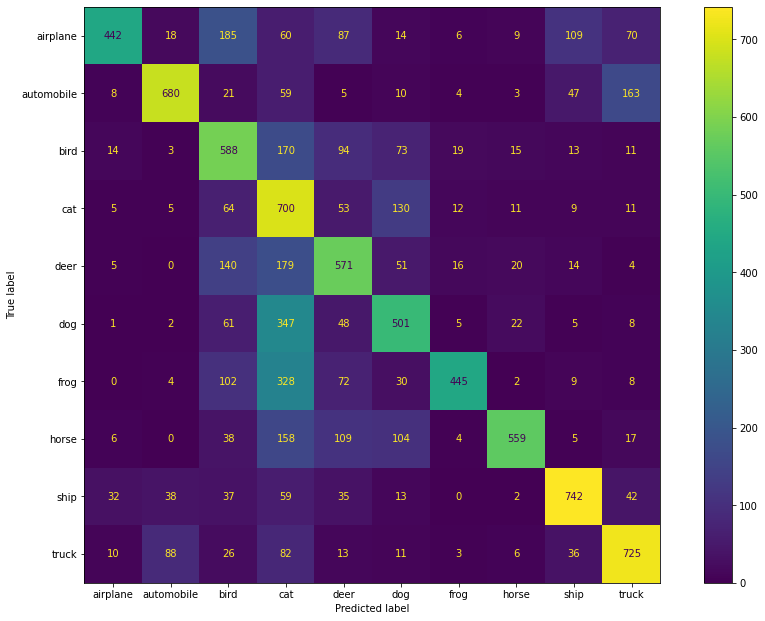

In [110]:
# Create confusion matrix and plot it
conf_matrix = confusion_matrix(y_test, y_pred.argmax(axis=1))
conf_matrix_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
conf_matrix_disp.plot(ax=plt.axes((2, 2, 2, 2)))
plt.show()

<font color='#4863A0'>As can be seen from the confusion matrix, the neural network distinguishes between two large classes of animals and vehicles, but often makes mistakes in determining their representatives, since they have certain similar outlines.</font>

## MNIST dataset

In [20]:
# Load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1, 1) / 255.0
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1, 1) / 255.0

# One-hot encode target data
y_train_oh = to_categorical(y_train, 10)
y_test_oh = to_categorical(y_test, 10)

In [21]:
# Instantiate model and train it
model_mnist = cnn_model(X_train.shape[1:], 10)
train_model(model_mnist, X_train, y_train_oh, X_test, y_test_oh, 64)

Epoch 1/10
938/938 [==============================] - 173s 183ms/step - loss: 0.1949 - accuracy: 0.9406 - val_loss: 0.1093 - val_accuracy: 0.9798
Epoch 2/10
938/938 [==============================] - 185s 197ms/step - loss: 0.0739 - accuracy: 0.9776 - val_loss: 0.0644 - val_accuracy: 0.9850
Epoch 3/10
938/938 [==============================] - 171s 182ms/step - loss: 0.0564 - accuracy: 0.9826 - val_loss: 0.0633 - val_accuracy: 0.9873
Epoch 4/10
938/938 [==============================] - 173s 185ms/step - loss: 0.0467 - accuracy: 0.9860 - val_loss: 0.0482 - val_accuracy: 0.9889
Epoch 5/10
938/938 [==============================] - 176s 188ms/step - loss: 0.0409 - accuracy: 0.9878 - val_loss: 0.0385 - val_accuracy: 0.9906
Epoch 6/10
938/938 [==============================] - 162s 172ms/step - loss: 0.0353 - accuracy: 0.9895 - val_loss: 0.0334 - val_accuracy: 0.9915
Epoch 7/10
938/938 [==============================] - 163s 174ms/step - loss: 0.0331 - accuracy: 0.9900 - val_loss: 0.0363 -

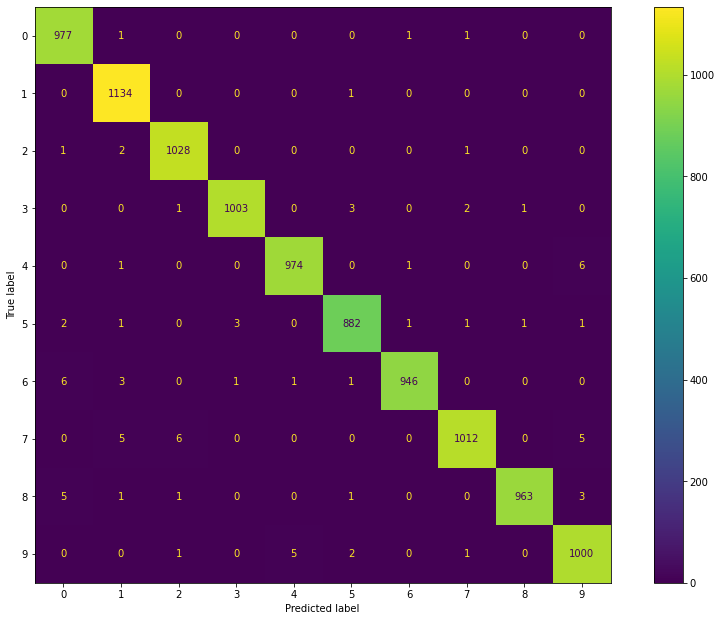

In [22]:
# Make predictions
y_pred = model_mnist.predict(X_test)

# Create confusion matrix and plot it
conf_matrix = confusion_matrix(y_test, y_pred.argmax(axis=1))
conf_matrix_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
    display_labels=["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])
conf_matrix_disp.plot(ax=plt.axes((2, 2, 2, 2)))
plt.show()

<font color='#4863A0'>As can be seen, this model is able to predict numbers from the MNIST dataset with almost 100% accuracy.</font>

## Extra

- Try training on additional datasets available with Keras. For example, the MNIST data (hand-written digits) will require virtually no code changes to solve.
- Play with different CNN architectures. Can you beat the performance of the net used in this exercise?